- ref. 

In [113]:
# load data
import pandas as pd, numpy as np
pd.set_option("display.width", 80)
pd.set_option("display.max_rows", 20)
import seaborn as sns, matplotlib.pyplot as plt
import multiprocessing as mp
n_cpus = mp.cpu_count()

train_df = pd.read_csv("./train.csv")   # 42000
#train_df = pd.read_csv("./train.csv", nrows=10000)
test_df = pd.read_csv("./test.csv")   # 28000
train_num = train_df.shape[0]
test_num = test_df.shape[0]
train_x = train_df.drop(['label'], axis=1)
train_y = train_df["label"]
test_x = test_df
all_df = pd.concat((train_x, test_df))

dfd = {'train': train_df, 'test': test_df, 'all': all_df}
for name,df in dfd.items():
    print(name, df.shape)
    print(df.head())

train (42000, 785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0

In [114]:
# check data
for name,df in dfd.items():
    print(name)
    print(df.info())
    #print(df.describe())   # doesn't show a lot of information

train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None
all
<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 419.2 MB
None


In [115]:
# check null
for name,df in dfd.items():
    print(name)
    isnull_ratio = df.isnull().sum()/df.isnull().count()
    print(isnull_ratio[isnull_ratio != 0].sort_values(ascending=False))

train
Series([], dtype: float64)
test
Series([], dtype: float64)
all
Series([], dtype: float64)


In [116]:
# check correlation (takes time)
# -> pixel436 has high correlation with label.. so what?
# correlations = train_df.astype(float).corr()['label'].sort_values(ascending=False)
# print(correlations.head())
# print(correlations.tail())

In [117]:
# check skewness (takes time)
# -> pixel367 has high skewness, but log/boxcox transform doesn't help
# from scipy.stats import skew
# skewness = all_df.apply(lambda x: skew(x)).sort_values(ascending=False)
# print(skewness.head())
# print(skewness.tail())
# all_df['pixel367'].hist(bins=50)
# plt.show()

In [118]:
# grid search (takes time)
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier
from sklearn.base import clone

train_x = all_df[:train_num]
test_x = all_df[train_num:]

# models = []
# C_list, gamma_list, degree_list = np.logspace(-2, 0, 3), np.logspace(-3, -1, 3), np.linspace(1, 3, 3)
# grid = [
#     {'C': C_list, 'kernel': ['poly'], 'gamma': gamma_list, 'degree': degree_list},
#     # {'C': C_list, 'kernel': ['sigmoid'], 'gamma': gamma_list},
#     # {'C': C_list, 'kernel': ['linear']},
#     # {'C': C_list, 'kernel': ['rbf'], 'gamma': gamma_list},
#     ]
# models.append(('svm', GridSearchCV(SVC(), grid, cv=3, n_jobs=n_cpus)))
# grid = [{'n_estimators': [1000], 'max_depth': [6,7,8], 'min_samples_leaf': [2,3], 'max_features' : ['sqrt']}]
# models.append(('random_forest', GridSearchCV(RandomForestClassifier(), grid, cv=3, n_jobs=n_cpus)))
# models.append(('extra_trees', GridSearchCV(ExtraTreesClassifier(), grid, cv=3, n_jobs=n_cpus)))
# grid = {'n_estimators': [1000], 'learning_rate' : [0.25, 0.5, 0.75]}
# models.append(('ada_boost', GridSearchCV(AdaBoostClassifier(), grid, cv=3, n_jobs=n_cpus)))
# grid = {'n_estimators': [1000], 'max_depth': [6,7,8], 'min_samples_leaf': [2,3]}
# models.append(('gradient_boosting', GridSearchCV(GradientBoostingClassifier(), grid, cv=3, n_jobs=n_cpus)))
# grid = {'max_iter': [1000], 'tol': [0.001]}
# models.append(('perceptron', GridSearchCV(Perceptron(max_iter=1000, tol=0.001), grid, cv=3, n_jobs=n_cpus)))
# models.append(('sgd_classifier', GridSearchCV(SGDClassifier(max_iter=1000, tol=0.001), grid, cv=3, n_jobs=n_cpus)))
# grid = {'n_neighbors': [2,3,4]}
# models.append(('k-nearest_neighbors', GridSearchCV(KNeighborsClassifier(), grid, cv=3, n_jobs=n_cpus)))
# grid = {}
# models.append(('logistic_regression', GridSerchCV(LogisticRegression(), grid, cv=3, n_jobs=n_cpus)))
# models.append(('gaussian_naive bayes', GridSearchCV(GaussianNB(), grid, cv=3, n_jobs=n_cpus)))
# models.append(('linear_svc', GridSearchCV(LinearSVC(), grid, cv=3, n_jobs=n_cpus)))
# models.append(('decision_tree', GridSearchCV(DecisionTreeClassifier(), grid, cv=3, n_jobs=n_cpus)))

# params = {}
# for name,model in models:
#     model.fit(train_x, train_y)
#     print(name, model.best_score_, model.best_params_)
#     params[name] = model.best_params_
#     # results = model.cv_results_
#     # for mean, std, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
#     #     print("{:0.3f} (+/-{:0.03f} for {}".format(mean, std, params))

# from the result of nrows=20000
params = {
    'k-nearest_neighbors': {'n_neighbors': 3},
    'sgd_classifier': {'max_iter': 1000, 'tol': 0.001},
    'perceptron': {'max_iter': 1000, 'tol': 0.001},
    'gradient_boosting': {'max_depth': 6, 'min_samples_leaf': 3, 'n_estimators': 1000},
    'ada_boost': {'learning_rate': 0.25, 'n_estimators': 1000},
    'extra_trees': {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 1000},
    'random_forest': {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 1000},
    'svm': {'C': 0.01, 'degree': 2.0, 'gamma': 0.001, 'kernel': 'poly'},
    'logistic_regression': {},
    'gaussian_naive bayes': {},
    'linear_svc': {},
    'decision_tree': {},
    }

svm_model = SVC(**params['svm'])
# bagging_svm_model = BaggingClassifier(base_estimator=clone(svm_model),
#                                       n_estimators=10, max_samples=0.9, max_features=0.2)
et_model = ExtraTreesClassifier(**params['extra_trees'])
# bagging_et_model = BaggingClassifier(base_estimator=clone(et_model),
#                                      n_estimators=10, max_samples=0.9, max_features=0.2)
knn_model = KNeighborsClassifier(**params['k-nearest_neighbors'])
# bagging_knn_model = BaggingClassifier(base_estimator=clone(knn_model),
#                                       n_estimators=10, max_samples=0.9, max_features=0.2)
lr_model = LogisticRegression(**params['logistic_regression'])
# stacking_model = StackingClassifier(classifiers=[clone(svm_model), clone(et_model), clone(knn_model)],
#                                     meta_classifier=clone(lr_model))
models = [
    ('svm', svm_model),
    # ('bagging_svm', bagging_svm_model),
    ('extra_trees', et_model),
    # ('bagging_extra_trees', bagging_et_model),
    ('random_forest', RandomForestClassifier(**params['random_forest'])),
    ('ada_boost', AdaBoostClassifier(**params['ada_boost'])),
    ('gradient_boosting', GradientBoostingClassifier(**params['gradient_boosting'])),
    ('perceptron', Perceptron(**params['perceptron'])),
    ('sgd_classifier', SGDClassifier(**params['sgd_classifier'])),
    ('k-nearest_neighbors', knn_model),
    # ('bagging_k-nearest_neighbors', bagging_knn_model),
    ('logistic_regression', lr_model),
    ('gaussian_naive bayes', GaussianNB(**params['gaussian_naive bayes'])),
    ('linear_svc', LinearSVC(**params['linear_svc'])),
    ('decision_tree', DecisionTreeClassifier(**params['decision_tree'])),
    # ('stacking', stacking_model),
    ]

In [119]:
# cross validation
from sklearn.model_selection import KFold, cross_validate
from multiprocessing import Manager
from sklearn.externals.joblib import Parallel, delayed

# k_fold = KFold(n_splits=3)
# with Manager() as manager:
#     results = manager.list()
#     def validate_one_model(name, model):
#          # Multiprocessing-backed parallel loops cannot be nested
#          scores = cross_validate(model, train_x, train_y, cv=k_fold, scoring='accuracy')
#          result = {}
#          result['model'] = name
#          result['test_mean'] = np.mean(scores['test_score'])
#          result['test_std'] = np.std(scores['test_score'])
#          result['train_mean'] = np.mean(scores['train_score'])
#          result['train_std'] = np.std(scores['train_score'])
#          results.append(result)
#     Parallel(n_jobs=n_cpus)(delayed(validate_one_model)(name, model) for name,model in models)
#     results_merged = {'model': [], 'test_mean': [], 'test_std': [], 'train_mean': [], 'train_std': []}
#     for result in results:
#         for k,v in result.items():
#             results_merged[k].append(v)
#     print(pd.DataFrame(results_merged).sort_values(by='test_mean', ascending=False))

In [120]:
# learn, predict and report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.externals.joblib import Parallel, delayed, dump
test_id = np.arange(1, test_num+1)
# results = {}
# def process_one_model(name, model):
#     model.fit(train_x, train_y)
#     predict_y = model.predict(train_x)
#     output = model.predict(test_x)
#     results[name] = output
#     print(output[:20])
#     submit = pd.DataFrame(data={'ImageId':test_id, 'Label':output})
#     submit.to_csv('{}_submit.csv'.format(name), index=False)
#     #dump(model, '{}.learn'.format(name))
#     print(name)
#     print(confusion_matrix(train_y, predict_y))
#     print(classification_report(train_y, predict_y))
# Parallel(n_jobs=n_cpus)(delayed(process_one_model)(name, model) for name,model in models)

In [121]:
!head svm_submit.csv

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


learning..
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
         acc      loss   val_acc  val_loss
11  0.987196  0.039662  0.987381  0.037124
12  0.988201  0.038215  0.988810  0.033280
13  0.989312  0.034392  0.988333  0.035691
14  0.989339  0.033950  0.987381  0.033301
15  0.989974  0.031808  0.987619  0.035447


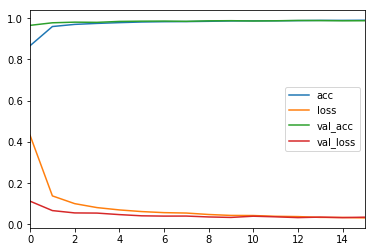

predicting..

28000/28000 [==============================] - ETA: 0s

predict:  [2 0 9 9 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0]


In [122]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, Callback

trainX = train_x.values.reshape(len(train_x.index), 28, 28, 1).astype('float32')/255
testX = test_x.values.reshape(len(test_x.index), 28, 28, 1).astype('float32')/255
trainY = train_y.values
# trainY = np_utils.to_categorical(train_y.values, num_classes=10)   # required for categorical_crossentropy

keras_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(rate=0.5),
    Dense(units=10, activation='softmax'),
])
keras_model.compile(loss='sparse_categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
# keras_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])   # worse
# print(keras_model.summary())

print('learning..')
class PrintProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(epoch, end=' ')
history = keras_model.fit(trainX, trainY, epochs=20, batch_size=128, validation_split=0.1,
                          callbacks=[EarlyStopping(patience=3), PrintProgress()], verbose=0)
print()
hist_df = pd.DataFrame({'loss': history.history['loss'], 'acc': history.history['acc'],
                        'val_loss': history.history['val_loss'], 'val_acc': history.history['val_acc']})
print(hist_df.tail())
hist_df.plot()
plt.show()

print('predicting..')
output = keras_model.predict_classes(testX)
print()
print('predict: ', output[:20])
submit = pd.DataFrame(data={'ImageId':test_id, 'Label':output})
submit.to_csv('nn_keras_submit.csv'.format(name), index=False)

In [ ]:
!head nn_keras_submit.csv

In [ ]:
# neural network with tensorflow (skflow -> contrib.learn -> estimator)
# import tensorflow as tf
# trainX = train_x/255
# testX = test_x/255
# trainY = train_y
# feature_columns = [tf.feature_column.numeric_column(k) for k in train_x.columns]
# tf_model = tf.estimator.DNNClassifier(hidden_units=[1000], n_classes=10, feature_columns=feature_columns)
# input_fn_train = tf.estimator.inputs.pandas_input_fn(x=trainX, y=trainY, shuffle=False)
# tf_model.train(input_fn=input_fn_train, steps=100)
# tf_model.evaluate(input_fn=input_fn_train, steps=10)
# #scores = cross_validate(tf_model, train_x, train_y, cv=k_fold, scoring='accuracy')   # throws an error
# input_fn_predict = tf.estimator.inputs.pandas_input_fn(x=testX, shuffle=False)
# generator = tf_model.predict(input_fn=input_fn_predict)
# output = [d['class_ids'][0] for d in generator]
# print(output[:20])
# submit = pd.DataFrame(data={'ImageId':test_id, 'Label':output})
# submit.to_csv('nn_tensor_submit.csv'.format(name), index=False)